# Convolutional Neural Network for Cat and Dogs

Convolutional neural networks on prepackaged data sets are essentially the "hello world" of machine learning.  For this project, I decided to take it one step further and download an outside data. 

In [2]:
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time
from tqdm import tqdm_notebook as tqdm
import cv2

## Data

* Data can be download at: https://www.microsoft.com/enus/download/confirmation.aspx?id=54765
* I put my data in the sub dir data

After unzipping the data, it expands to have a folder "PetImages" that has a folder of cat and one of dog images. 

### Exploring the data: 
After a quick visual analysis of the data, I found that the images have different sizes.  So here I do some exploration to see how I can standardize the data.  

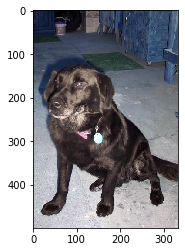

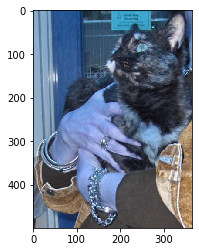

In [4]:
dataDir = "./data/PetImages"
categories = ["Dog", "Cat"]

path_dog = os.path.join(dataDir, categories[0])
all_dog_paths = os.listdir(path_dog)
img_dog = cv2.imread(os.path.join(dataDir, categories[0],all_dog_paths[0]))
plt.imshow(img_dog)
plt.show()


path_cat = os.path.join(dataDir, categories[1])
all_cat_paths = os.listdir(path_cat)
img_cat = cv2.imread(os.path.join(dataDir, categories[1],all_cat_paths[0]))
plt.imshow(img_cat)
plt.show()



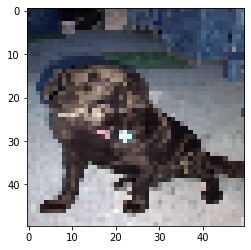

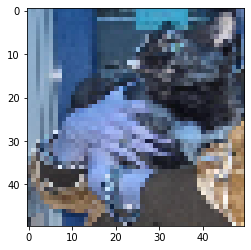

In [5]:
img_size = 50

path_dog = os.path.join(dataDir, categories[0])
all_dog_paths = os.listdir(path_dog)
img_dog = cv2.imread(os.path.join(dataDir, categories[0],all_dog_paths[0]))
img_dog = cv2.resize(img_dog, (img_size, img_size)) 
plt.imshow(img_dog)
plt.show()


path_cat = os.path.join(dataDir, categories[1])
all_cat_paths = os.listdir(path_cat)
img_cat = cv2.imread(os.path.join(dataDir, categories[1],all_cat_paths[0]))
img_cat = cv2.resize(img_cat, (img_size, img_size)) 
plt.imshow(img_cat)
plt.show()


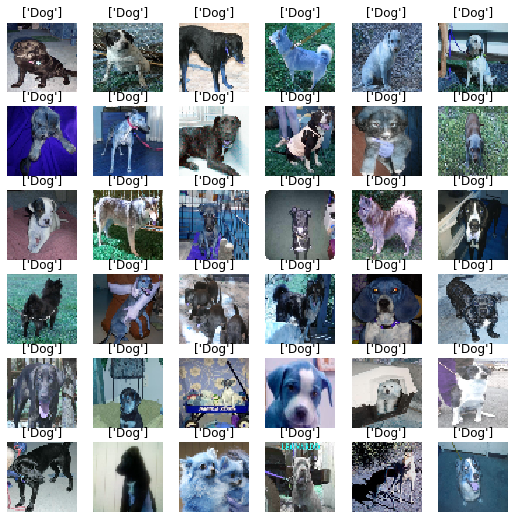

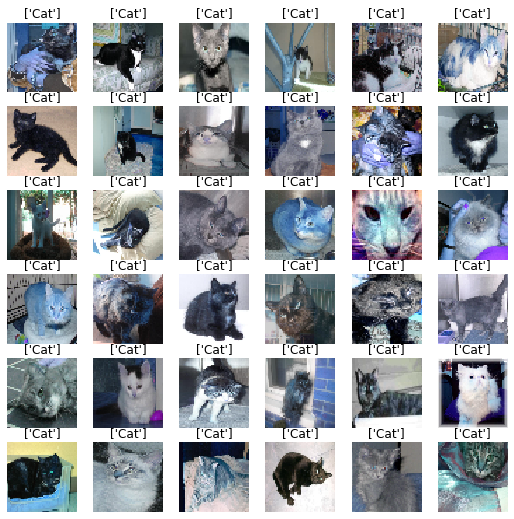

In [6]:
# From above, i suspect that i can use image pixels to size 100. But will check:
img_rows = 6
img_cols = 6

plt.figure(figsize=(img_cols*1.5, img_rows * 1.5))
for row in range(img_rows):
    for col in range(img_cols):
        index = img_cols * row + col
        img_dog = cv2.imread(os.path.join(dataDir, categories[0],all_dog_paths[index]))
        img_dog = cv2.resize(img_dog, (img_size, img_size)) 
        plt.subplot(img_rows, img_cols, index + 1)
        plt.imshow(img_dog, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title([categories[0]])
plt.show()


plt.figure(figsize=(img_cols*1.5, img_rows * 1.5))
for row in range(img_rows):
    for col in range(img_cols):
        index = img_cols * row + col
        img_cat = cv2.imread(os.path.join(dataDir, categories[1],all_cat_paths[index]))
        img_cat = cv2.resize(img_cat, (img_size, img_size)) 
        plt.subplot(img_rows, img_cols, index + 1)
        plt.imshow(img_cat, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title([categories[1]])
plt.show()

Ok, so from my 6x6 arrays, I can visualize and distinguish the difference between cats and dogs. Future runs of this could work with a larger initial image size. However, considering larger run times = more computation, I am ok with where I am

### Import the Data

To improt the images (cats and dogs), I will write a funciton and ignore exceptions.  

In [7]:
def create_training_data():
    training_data = []
    for category in categories: 
        path = os.path.join(dataDir,category)  
        class_num = categories.index(category) 
        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (img_size, img_size)) 
                training_data.append([img_array, class_num])  
            except Exception as e:  
                pass
    return training_data

raw_training_data = create_training_data()

### Package data:

I will now package the data to pass through a keras model.

In [11]:
import random 
shuffled_data = raw_training_data
random.shuffle(shuffled_data)

In [18]:
X = []
y = []

for image_data, label in shuffled_data:
    X.append(image_data)
    y.append(label)

#make sure even split of cats and dogs:
print(f"There are {y.count(0)} images of dogs and {y.count(1)} images of cats.")

#need np.arrays for keras
X = np.array(X).reshape(-1, img_size, img_size,1)
y=np.array(y).reshape(-1,1)

#normalize pixel values
X = X/255.0

print(f" Total sampels: {X.shape[0]} \n Image width: {X.shape[1]} \n Image height: {X.shape[2]} \n Channels: {X.shape[3]}")


There are 12470 images of dogs and 12476 images of cats.
 Total sampels: 24946 
 Image width: 50 
 Image height: 50 
 Channels: 1


## Build Model

I will use a basic convolutional neural network.

In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size = 3, padding = "same", input_shape=X.shape[1:]),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size = 2),
    
    keras.layers.Conv2D(filters=64, kernel_size = 3, padding = "same"),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size = 2),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(64),
    
    keras.layers.Dense(1, activation = "sigmoid")  
])

In [20]:
model.compile(loss = "binary_crossentropy",
              optimizer='adam',
              metrics = ["accuracy"])

In [21]:
history = model.fit(X, y, 
                    epochs = 10,
                    validation_split = 0.3,
                    batch_size = 50)

Train on 17462 samples, validate on 7484 samples
Epoch 1/10
17462/17462 [==============================] - 109s 6ms/sample - loss: 0.6464 - accuracy: 0.6286 - val_loss: 0.6161 - val_accuracy: 0.6706
Epoch 2/10
17462/17462 [==============================] - 96s 5ms/sample - loss: 0.5758 - accuracy: 0.7020 - val_loss: 0.5864 - val_accuracy: 0.6857
Epoch 3/10
17462/17462 [==============================] - 94s 5ms/sample - loss: 0.5343 - accuracy: 0.7327 - val_loss: 0.5378 - val_accuracy: 0.7332
Epoch 4/10
17462/17462 [==============================] - 96s 6ms/sample - loss: 0.5046 - accuracy: 0.7555 - val_loss: 0.5390 - val_accuracy: 0.7382
Epoch 5/10
17462/17462 [==============================] - 96s 6ms/sample - loss: 0.4794 - accuracy: 0.7755 - val_loss: 0.5067 - val_accuracy: 0.7551
Epoch 6/10
17462/17462 [==============================] - 112s 6ms/sample - loss: 0.4553 - accuracy: 0.7846 - val_loss: 0.5034 - val_accuracy: 0.7569
Epoch 7/10
17462/17462 [==============================]